In [8]:
import val
from PIL import Image
from sympy.combinatorics import Subset


def verify_and_clean_dataset(root_dir='food11'):
    print("Проверка датасета на повреждённые или маленькие изображения...\n")
    removed_count = 0

    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        if not os.path.isdir(split_dir):
            print(f"Пропускаю {split_dir} (не найдена папка)")
            continue

        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    if os.path.getsize(img_path) == 0:
                        raise ValueError("Файл пустой")

                    img = Image.open(img_path)
                    img.verify()
                    img = Image.open(img_path)
                    img.load()

                    if img.size[0] < 50 or img.size[1] < 50:
                        os.remove(img_path)
                        removed_count += 1
                        print(f"Удалено (слишком маленькое): {img_path}")

                except Exception as e:
                    try:
                        os.remove(img_path)
                        removed_count += 1
                        print(f"Удалено (поврежденное): {img_path} — {e}")
                    except:
                        print(f"Не удалось удалить {img_path}")

    print(f"\nПроверка завершена. Удалено файлов: {removed_count}")

verify_and_clean_dataset('food11')


Проверка датасета на повреждённые или маленькие изображения...


Проверка завершена. Удалено файлов: 0


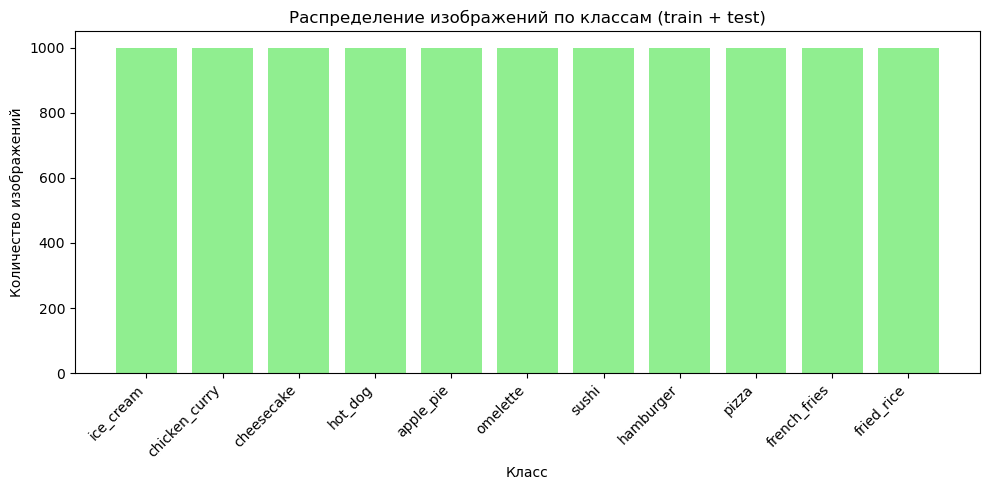

In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import os

def plot_total_distribution(root_dir='food11'):
    total_counts = Counter()

    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            n = len(os.listdir(class_path))
            total_counts[class_name] += n

    plt.figure(figsize=(10,5))
    plt.bar(total_counts.keys(), total_counts.values(), color='lightgreen')
    plt.title("Распределение изображений по классам (train + test)")
    plt.xlabel("Класс")
    plt.ylabel("Количество изображений")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_total_distribution("food11")


In [12]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset


data_dir = "food11"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

batch_size = 32
num_epochs = 30
learning_rate = 1e-3

# Early stopping
patience = 5
best_acc = 0.0
patience_counter = 0

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
full_train_clean = datasets.ImageFolder(train_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split на train/val (80/20)
train_size = int(0.8 * len(full_train_augmented))
val_size = len(full_train_augmented) - train_size

# Генерируем индексы для split
indices = list(range(len(full_train_augmented)))
np.random.seed(42)  # Для воспроизводимости
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Создаём датасеты с правильными трансформациями
train_dataset = Subset(full_train_augmented, train_indices)
val_dataset = Subset(full_train_clean, val_indices)

num_classes = len(full_train_augmented.classes)
class_names = full_train_augmented.classes
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Классы ({num_classes}): {class_names}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Заморозка
for param in model.features.parameters():
    param.requires_grad = False

# Заменяем классификатор
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

writer = SummaryWriter(log_dir="runs/food11_efficientnet_B0")

def plot_confusion_matrix(cm, class_names, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - Epoch {epoch+1}')
    return fig

# Функция для оценки модели с мультиклассовыми метриками
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels, cm


# Обучение
start_time = time.time()
print("\nОбучение (только классификатор)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_cm = evaluate_model(model, val_loader, criterion, device)

    # Логи в TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)
    writer.add_scalar("Precision/Validation", val_prec, epoch)
    writer.add_scalar("Recall/Validation", val_rec, epoch)
    writer.add_scalar("F1/Validation", val_f1, epoch)
    writer.add_scalar("Learning_Rate", optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        cm = confusion_matrix(val_labels, val_preds)
        cm_fig = plot_confusion_matrix(cm, class_names, epoch)
        writer.add_figure("Confusion_Matrix/Validation", cm_fig, epoch)
        plt.close(cm_fig)

    scheduler.step(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time
    est_remaining = (elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train: L={avg_train_loss:.3f} A={train_acc:.1f}% | "
          f"Val: L={val_loss:.3f} A={val_acc:.1f}% | "
          f"LR={optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {epoch_time:.0f}s | ETA: {est_remaining/60:.1f}min")

    # Early stopping и сохранен е мождели
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }, "best_efficientnet_B0_food11.pth")
        print(f"Лучшая модель сохранена! Val Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Нет улучшения {patience_counter}/{patience} эпох")

        if patience_counter >= patience:
            print(f"\nОстановка на эпохе {epoch+1}")
            print(f"Лучший результат: {best_acc:.2f}%")
            break

print("Финальная оценка на Test Set...")
checkpoint = torch.load("best_efficientnet_B0_food11.pth")
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc:.2f}% | Precision: {test_prec:.3f} | Recall: {test_rec:.3f} | F1: {test_f1:.3f}")

total_time = time.time() - start_time
print(f"Общее время: {total_time/60:.1f} минут")
print(f"Лучшая Val Accuracy: {best_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Модель сохранена: best_efficientnet_B0_food11.pth")

writer.close()

Устройство: mps
Train: 7920 | Val: 1980 | Test: 1100
Классы (11): ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/artemsotnikov/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100.0%
/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Обучение (только классификатор)


Epoch 01/30 | Train: L=1.548 A=54.4% | Val: L=1.006 A=72.7% | LR=1.00e-03 | Time: 153s | ETA: 73.8min
Лучшая модель сохранена! Val Acc: 72.73%


Epoch 02/30 | Train: L=1.133 A=64.7% | Val: L=0.855 A=74.7% | LR=1.00e-03 | Time: 162s | ETA: 73.5min
Лучшая модель сохранена! Val Acc: 74.70%


Epoch 03/30 | Train: L=1.042 A=67.1% | Val: L=0.805 A=76.8% | LR=1.00e-03 | Time: 165s | ETA: 71.9min
Лучшая модель сохранена! Val Acc: 76.82%


Epoch 04/30 | Train: L=0.979 A=68.4% | Val: L=0.764 A=76.8% | LR=1.00e-03 | Time: 185s | ETA: 72.0min
Нет улучшения 1/5 эпох


Epoch 05/30 | Train: L=0.962 A=69.3% | Val: L=0.761 A=77.0% | LR=1.00e-03 | Time: 157s | ETA: 68.5min
Лучшая модель сохранена! Val Acc: 77.02%


Epoch 06/30 | Train: L=0.933 A=70.3% | Val: L=0.755 A=76.4% | LR=1.00e-03 | Time: 147s | ETA: 64.6min
Нет улучшения 1/5 эпох


Epoch 07/30 | Train: L=0.931 A=69.8% | Val: L=0.735 A=77.1% | LR=1.00e-03 | Time: 144s | ETA: 61.0min
Лучшая модель сохранена! Val Acc: 77.12%


Epoch 08/30 | Train: L=0.913 A=70.7% | Val: L=0.742 A=77.1% | LR=1.00e-03 | Time: 148s | ETA: 57.8min
Нет улучшения 1/5 эпох


Epoch 09/30 | Train: L=0.920 A=70.6% | Val: L=0.719 A=77.3% | LR=1.00e-03 | Time: 152s | ETA: 55.0min
Лучшая модель сохранена! Val Acc: 77.27%


Epoch 10/30 | Train: L=0.913 A=70.5% | Val: L=0.722 A=77.3% | LR=1.00e-03 | Time: 180s | ETA: 53.1min
Лучшая модель сохранена! Val Acc: 77.32%


Epoch 11/30 | Train: L=0.898 A=70.4% | Val: L=0.733 A=77.8% | LR=1.00e-03 | Time: 160s | ETA: 50.5min
Лучшая модель сохранена! Val Acc: 77.83%


Epoch 12/30 | Train: L=0.887 A=71.5% | Val: L=0.712 A=78.4% | LR=1.00e-03 | Time: 154s | ETA: 47.7min
Лучшая модель сохранена! Val Acc: 78.38%


Epoch 13/30 | Train: L=0.880 A=71.6% | Val: L=0.712 A=78.2% | LR=1.00e-03 | Time: 147s | ETA: 44.8min
Нет улучшения 1/5 эпох


Epoch 14/30 | Train: L=0.882 A=71.7% | Val: L=0.720 A=77.7% | LR=1.00e-03 | Time: 146s | ETA: 41.9min
Нет улучшения 2/5 эпох


Epoch 15/30 | Train: L=0.884 A=71.6% | Val: L=0.727 A=77.0% | LR=1.00e-03 | Time: 145s | ETA: 39.1min
Нет улучшения 3/5 эпох


Epoch 16/30 | Train: L=0.878 A=71.7% | Val: L=0.716 A=77.7% | LR=5.00e-04 | Time: 145s | ETA: 36.3min
Нет улучшения 4/5 эпох


Epoch 17/30 | Train: L=0.860 A=72.5% | Val: L=0.708 A=78.1% | LR=5.00e-04 | Time: 149s | ETA: 33.6min
Нет улучшения 5/5 эпох

Остановка на эпохе 17
Лучший результат: 78.38%
Финальная оценка на Test Set...


/var/folders/pp/nnh10rws3jl0kc34jz4381080000gn/T/ipykernel_41469/913048568.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_efficientnet_B

Test Loss: 0.755 | Accuracy: 76.45% | Precision: 0.769 | Recall: 0.765 | F1: 0.764
Confusion matrix сохранена: confusion_matrix_test.png
Общее время: 44.2 минут
Лучшая Val Accuracy: 78.38%
Test Accuracy: 76.45%
Модель сохранена: best_efficientnet_B0_food11.pth


<Figure size 640x480 with 0 Axes>

In [15]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset
from collections import Counter

data_dir = "food11"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

batch_size = 32
num_epochs = 50  # Увеличили — будем дообучать глубже
learning_rate_classifier = 1e-3
learning_rate_features = 1e-5  # Меньше для размороженных слоёв

patience = 7  # Больше терпения при fine-tuning
best_acc = 0.0
patience_counter = 0

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
full_train_clean = datasets.ImageFolder(train_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split на train/val (80/20)
train_size = int(0.8 * len(full_train_augmented))
val_size = len(full_train_augmented) - train_size

indices = list(range(len(full_train_augmented)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_train_augmented, train_indices)
val_dataset = Subset(full_train_clean, val_indices)

num_classes = len(full_train_augmented.classes)
class_names = full_train_augmented.classes
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Классы ({num_classes}): {class_names}")

# Получаем метки из train_dataset
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
print("Распределение классов в train:", class_counts)

# Вычисляем веса для каждого класса
class_weights = [len(train_labels) / (num_classes * class_counts[i]) for i in range(num_classes)]
sample_weights = [class_weights[label] for label in train_labels]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Обновлённый train_loader с семплированием
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

for name, param in model.named_parameters():
    if "features.7" in name or "features.8" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


print("\nОбучаемые параметры:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  [Train] {name}")

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.tensor(class_weights).to(device))
print(f"Label Smoothing: 0.1 | Class weights: {class_weights}")

optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': learning_rate_features},
    {'params': model.classifier.parameters(), 'lr': learning_rate_classifier}
])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=4, verbose=True
)

writer = SummaryWriter(log_dir="runs/food11_efficientnet_B0_finetune")

def plot_confusion_matrix(cm, class_names, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - Epoch {epoch+1}')
    return fig

def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels, cm

start_time = time.time()
print("\nОбучение (fine-tuning + label smoothing + weighted sampling)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_cm = evaluate_model(model, val_loader, criterion, device)

    # Логи
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)
    writer.add_scalar("Precision/Validation", val_prec, epoch)
    writer.add_scalar("Recall/Validation", val_rec, epoch)
    writer.add_scalar("F1/Validation", val_f1, epoch)
    writer.add_scalar("Learning_Rate_Classifier", optimizer.param_groups[1]['lr'], epoch)
    writer.add_scalar("Learning_Rate_Features", optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        cm_fig = plot_confusion_matrix(val_cm, class_names, epoch)
        writer.add_figure("Confusion_Matrix/Validation", cm_fig, epoch)
        plt.close(cm_fig)

    scheduler.step(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time
    est_remaining = (elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train: L={avg_train_loss:.3f} A={train_acc:.1f}% | "
          f"Val: L={val_loss:.3f} A={val_acc:.1f}% | "
          f"LR_c={optimizer.param_groups[1]['lr']:.2e} LR_f={optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {epoch_time:.0f}s | ETA: {est_remaining/60:.1f}min")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }, "upgrade_efficientnet_B0_finetune_food11.pth")
        print(f"Лучшая модель сохранена! Val Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Нет улучшения {patience_counter}/{patience} эпох")
        if patience_counter >= patience:
            print(f"\nОстановка на эпохе {epoch+1}")
            print(f"Лучший результат: {best_acc:.2f}%")
            break

print("Финальная оценка на Test Set...")
checkpoint = torch.load("upgrade_efficientnet_B0_finetune_food11.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc:.2f}% | Precision: {test_prec:.3f} | Recall: {test_rec:.3f} | F1: {test_f1:.3f}")

# Сохраняем матрицу
cm_fig = plot_confusion_matrix(test_cm, class_names, -1)
cm_fig.savefig("confusion_matrix_test_finetune.png")
plt.close(cm_fig)
print("Confusion matrix сохранена: confusion_matrix_test_finetune.png")

total_time = time.time() - start_time
print(f"Общее время: {total_time/60:.1f} минут")
print(f"Лучшая Val Accuracy: {best_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Модель сохранена: upgrade_efficientnet_B0_finetune_food11.pth")

writer.close()

Устройство: mps
Train: 7920 | Val: 1980 | Test: 1100
Классы (11): ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Распределение классов в train: Counter({2: 735, 6: 729, 5: 728, 0: 727, 10: 721, 9: 720, 4: 717, 8: 716, 1: 712, 7: 708, 3: 707})

Обучаемые параметры:
  [Train] features.7.0.block.0.0.weight
  [Train] features.7.0.block.0.1.weight
  [Train] features.7.0.block.0.1.bias
  [Train] features.7.0.block.1.0.weight
  [Train] features.7.0.block.1.1.weight
  [Train] features.7.0.block.1.1.bias
  [Train] features.7.0.block.2.fc1.weight
  [Train] features.7.0.block.2.fc1.bias
  [Train] features.7.0.block.2.fc2.weight
  [Train] features.7.0.block.2.fc2.bias
  [Train] features.7.0.block.3.0.weight
  [Train] features.7.0.block.3.1.weight
  [Train] features.7.0.block.3.1.bias
  [Train] features.8.0.weight
  [Train] features.8.1.weight
  [Train] features.8.1.bias
  [Train] classifier.1.weight
  [T

/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Label Smoothing: 0.1 | Class weights: [0.9903713892709766, 1.0112359550561798, 0.9795918367346939, 1.0183875530410185, 1.00418410041841, 0.989010989010989, 0.9876543209876543, 1.0169491525423728, 1.005586592178771, 1.0, 0.9986130374479889]

Обучение (fine-tuning + label smoothing + weighted sampling)


Epoch 01/50 | Train: L=1.646 A=55.9% | Val: L=1.258 A=72.0% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 179s | ETA: 146.2min
Лучшая модель сохранена! Val Acc: 71.97%


Epoch 02/50 | Train: L=1.325 A=68.1% | Val: L=1.168 A=74.9% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 183s | ETA: 144.9min
Лучшая модель сохранена! Val Acc: 74.90%


Epoch 03/50 | Train: L=1.270 A=70.2% | Val: L=1.131 A=77.2% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 177s | ETA: 140.9min
Лучшая модель сохранена! Val Acc: 77.22%


Epoch 04/50 | Train: L=1.231 A=71.2% | Val: L=1.095 A=79.1% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 149s | ETA: 132.0min
Лучшая модель сохранена! Val Acc: 79.09%


Epoch 05/50 | Train: L=1.216 A=72.4% | Val: L=1.089 A=79.6% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 532s | ETA: 183.1min
Лучшая модель сохранена! Val Acc: 79.65%


Epoch 06/50 | Train: L=1.180 A=73.9% | Val: L=1.084 A=79.8% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 135s | ETA: 165.8min
Лучшая модель сохранена! Val Acc: 79.85%


Epoch 07/50 | Train: L=1.168 A=74.9% | Val: L=1.076 A=79.8% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 146s | ETA: 153.8min
Нет улучшения 1/7 эпох


Epoch 08/50 | Train: L=1.161 A=75.0% | Val: L=1.059 A=80.7% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 150s | ETA: 144.6min
Лучшая модель сохранена! Val Acc: 80.71%


Epoch 09/50 | Train: L=1.152 A=75.6% | Val: L=1.063 A=80.4% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 155s | ETA: 137.3min
Нет улучшения 1/7 эпох


Epoch 10/50 | Train: L=1.140 A=76.0% | Val: L=1.057 A=81.2% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 156s | ETA: 130.9min
Лучшая модель сохранена! Val Acc: 81.21%


Epoch 11/50 | Train: L=1.129 A=76.4% | Val: L=1.054 A=81.4% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 149s | ETA: 124.8min
Лучшая модель сохранена! Val Acc: 81.41%


Epoch 12/50 | Train: L=1.114 A=76.9% | Val: L=1.047 A=80.9% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 1008s | ETA: 164.7min
Нет улучшения 1/7 эпох


Epoch 13/50 | Train: L=1.124 A=76.7% | Val: L=1.048 A=81.9% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 143s | ETA: 154.8min
Лучшая модель сохранена! Val Acc: 81.87%


Epoch 14/50 | Train: L=1.118 A=76.6% | Val: L=1.046 A=81.3% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 156s | ETA: 146.6min
Нет улучшения 1/7 эпох


Epoch 15/50 | Train: L=1.098 A=77.9% | Val: L=1.061 A=80.9% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 150s | ETA: 138.8min
Нет улучшения 2/7 эпох


Epoch 16/50 | Train: L=1.104 A=77.3% | Val: L=1.047 A=81.1% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 150s | ETA: 131.8min
Нет улучшения 3/7 эпох


Epoch 17/50 | Train: L=1.094 A=78.0% | Val: L=1.050 A=81.3% | LR_c=1.00e-03 LR_f=1.00e-05 | Time: 159s | ETA: 125.5min
Нет улучшения 4/7 эпох


Epoch 18/50 | Train: L=1.085 A=78.4% | Val: L=1.046 A=81.0% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 175s | ETA: 120.1min
Нет улучшения 5/7 эпох


Epoch 19/50 | Train: L=1.072 A=78.6% | Val: L=1.038 A=81.5% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 187s | ETA: 115.3min
Нет улучшения 6/7 эпох


Epoch 20/50 | Train: L=1.080 A=78.6% | Val: L=1.029 A=81.4% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 203s | ETA: 111.1min
Нет улучшения 7/7 эпох

Остановка на эпохе 20
Лучший результат: 81.87%
Финальная оценка на Test Set...
Test Loss: 1.081 | Accuracy: 79.00% | Precision: 0.792 | Recall: 0.790 | F1: 0.790
Confusion matrix сохранена: confusion_matrix_test_finetune.png
Общее время: 74.3 минут
Лучшая Val Accuracy: 81.87%
Test Accuracy: 79.00%
Модель сохранена: upgrade_efficientnet_B0_finetune_food11.pth


In [16]:
def tta_predict(model, loader, device, num_augs=5):
    model.eval()
    all_preds = []

    transforms_list = [
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.RandomAffine(degrees=5, scale=(0.95, 1.05))
    ]

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            probs = torch.zeros(images.size(0), num_classes, device=device)

            # Оригинал
            probs += torch.softmax(model(images), dim=1)

            # Аугментации
            for t in transforms_list:
                aug_imgs = t(images)
                probs += torch.softmax(model(aug_imgs), dim=1)

            probs /= (1 + len(transforms_list))
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [17]:
# Замени финальную оценку:
test_preds = tta_predict(model, test_loader, device, num_augs=5)
test_labels = [label for _, label in test_loader.dataset]
test_acc = 100.0 * np.mean(np.array(test_preds) == np.array(test_labels))
print(f"TTA Test Accuracy: {test_acc:.2f}%")

TTA Test Accuracy: 82.09%


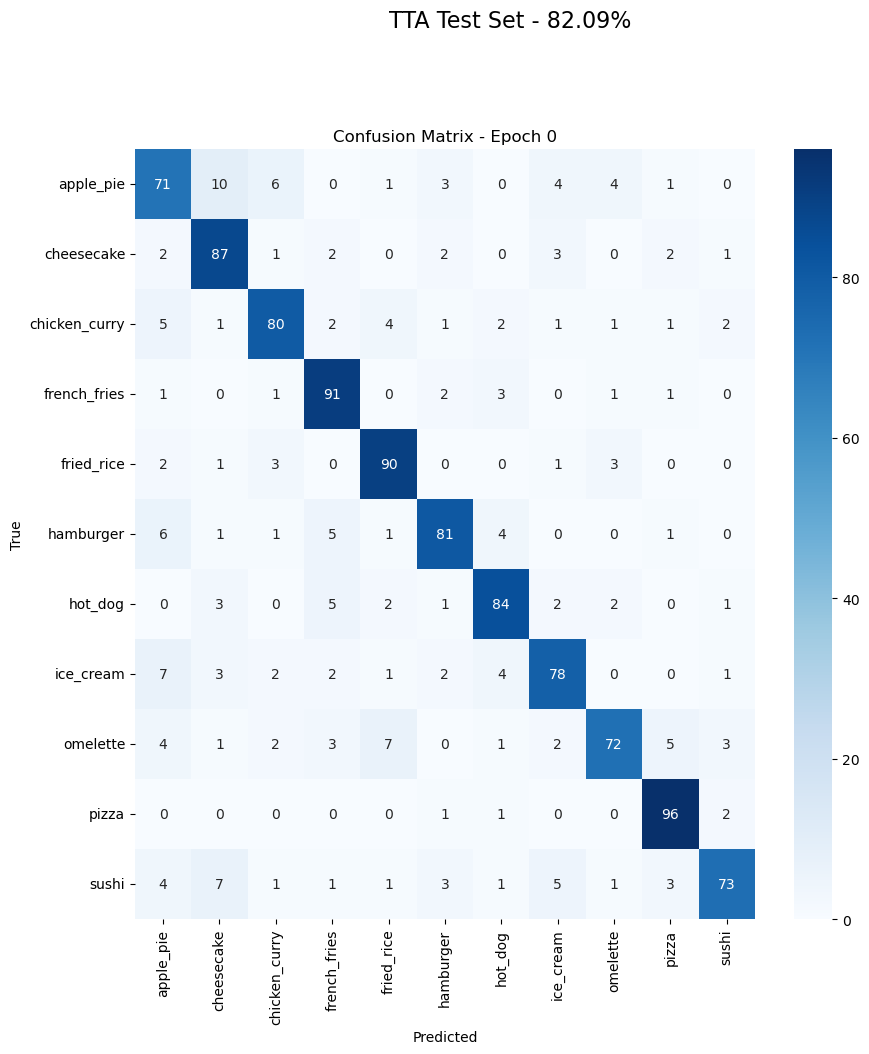

In [18]:
cm_tta = confusion_matrix(test_labels, test_preds)
cm_fig = plot_confusion_matrix(cm_tta, class_names, epoch=-1)
cm_fig.suptitle("TTA Test Set - 82.09%", fontsize=16, y=1.02)
cm_fig.savefig("FINAL_confusion_matrix_TTA_82.09%.png", dpi=200, bbox_inches='tight')
plt.show()

In [20]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset
from collections import Counter

data_dir = "food11"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

batch_size = 32
num_epochs = 50  # Увеличили — будем дообучать глубже
learning_rate_classifier = 1e-3
learning_rate_features = 1e-5  # Меньше для размороженных слоёв

patience = 7  # Больше терпения при fine-tuning
best_acc = 0.0
patience_counter = 0

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
full_train_clean = datasets.ImageFolder(train_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split на train/val (80/20)
train_size = int(0.8 * len(full_train_augmented))
val_size = len(full_train_augmented) - train_size

indices = list(range(len(full_train_augmented)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_train_augmented, train_indices)
val_dataset = Subset(full_train_clean, val_indices)

num_classes = len(full_train_augmented.classes)
class_names = full_train_augmented.classes
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Классы ({num_classes}): {class_names}")

train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
print("Распределение классов в train:", class_counts)

# Вычисляем веса для каждого класса
class_weights = [len(train_labels) / (num_classes * class_counts[i]) for i in range(num_classes)]
sample_weights = [class_weights[label] for label in train_labels]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Разморозка последних блоков
for name, param in model.named_parameters():
    if "features.7" in name or "features.8" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

# Оптимизатор
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 5e-6},
    {'params': model.classifier.parameters(), 'lr': 5e-4}
])

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.tensor(class_weights).to(device))

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, verbose=True)

writer = SummaryWriter(log_dir="runs/food11_efficientnet_B3")

def plot_confusion_matrix(cm, class_names, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - Epoch {epoch+1}')
    return fig

def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels, cm

start_time = time.time()
print("\nОбучение (fine-tuning + label smoothing + weighted sampling)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_cm = evaluate_model(model, val_loader, criterion, device)

    # Логи
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)
    writer.add_scalar("Precision/Validation", val_prec, epoch)
    writer.add_scalar("Recall/Validation", val_rec, epoch)
    writer.add_scalar("F1/Validation", val_f1, epoch)
    writer.add_scalar("Learning_Rate_Classifier", optimizer.param_groups[1]['lr'], epoch)
    writer.add_scalar("Learning_Rate_Features", optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        cm_fig = plot_confusion_matrix(val_cm, class_names, epoch)
        writer.add_figure("Confusion_Matrix/Validation", cm_fig, epoch)
        plt.close(cm_fig)

    scheduler.step(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time
    est_remaining = (elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train: L={avg_train_loss:.3f} A={train_acc:.1f}% | "
          f"Val: L={val_loss:.3f} A={val_acc:.1f}% | "
          f"LR_c={optimizer.param_groups[1]['lr']:.2e} LR_f={optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {epoch_time:.0f}s | ETA: {est_remaining/60:.1f}min")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }, "efficientnet_B3_food11.pth")
        print(f"Лучшая модель сохранена! Val Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Нет улучшения {patience_counter}/{patience} эпох")
        if patience_counter >= patience:
            print(f"\nОстановка на эпохе {epoch+1}")
            print(f"Лучший результат: {best_acc:.2f}%")
            break


print("Финальная оценка на Test Set...")
checkpoint = torch.load("efficientnet_B3_food11.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc:.2f}% | Precision: {test_prec:.3f} | Recall: {test_rec:.3f} | F1: {test_f1:.3f}")

# Сохраняем матрицу
cm_fig = plot_confusion_matrix(test_cm, class_names, -1)
cm_fig.savefig("confusion_matrix_test_В3.png")
plt.close(cm_fig)
print("Confusion matrix сохранена: confusion_matrix_test_B3.png")

total_time = time.time() - start_time
print(f"Общее время: {total_time/60:.1f} минут")
print(f"Лучшая Val Accuracy: {best_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Модель сохранена: efficientnet_B3_food11.pth")

writer.close()

Устройство: mps
Train: 7920 | Val: 1980 | Test: 1100
Классы (11): ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Распределение классов в train: Counter({2: 735, 6: 729, 5: 728, 0: 727, 10: 721, 9: 720, 4: 717, 8: 716, 1: 712, 7: 708, 3: 707})


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /Users/artemsotnikov/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100.0%
/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Обучение (fine-tuning + label smoothing + weighted sampling)


Epoch 01/50 | Train: L=1.865 A=51.8% | Val: L=1.413 A=71.8% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 232s | ETA: 189.7min
Лучшая модель сохранена! Val Acc: 71.77%


Epoch 02/50 | Train: L=1.431 A=65.2% | Val: L=1.211 A=75.7% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 236s | ETA: 187.6min
Лучшая модель сохранена! Val Acc: 75.71%


Epoch 03/50 | Train: L=1.300 A=69.4% | Val: L=1.135 A=77.7% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 307s | ETA: 202.8min
Лучшая модель сохранена! Val Acc: 77.73%


Epoch 04/50 | Train: L=1.266 A=70.0% | Val: L=1.107 A=79.0% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 299s | ETA: 206.7min
Лучшая модель сохранена! Val Acc: 78.99%


Epoch 05/50 | Train: L=1.240 A=71.7% | Val: L=1.083 A=79.7% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 287s | ETA: 204.8min
Лучшая модель сохранена! Val Acc: 79.75%


Epoch 06/50 | Train: L=1.202 A=73.2% | Val: L=1.056 A=80.7% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 262s | ETA: 198.9min
Лучшая модель сохранена! Val Acc: 80.71%


Epoch 07/50 | Train: L=1.195 A=73.4% | Val: L=1.059 A=80.5% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 308s | ETA: 198.2min
Нет улучшения 1/7 эпох


Epoch 08/50 | Train: L=1.174 A=74.6% | Val: L=1.057 A=80.8% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 364s | ETA: 201.3min
Лучшая модель сохранена! Val Acc: 80.81%


Epoch 09/50 | Train: L=1.170 A=74.3% | Val: L=1.036 A=82.5% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 218s | ETA: 191.3min
Лучшая модель сохранена! Val Acc: 82.47%


Epoch 10/50 | Train: L=1.156 A=75.0% | Val: L=1.034 A=82.7% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 213s | ETA: 182.6min
Лучшая модель сохранена! Val Acc: 82.73%


Epoch 11/50 | Train: L=1.164 A=74.6% | Val: L=1.027 A=83.0% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 210s | ETA: 174.3min
Лучшая модель сохранена! Val Acc: 82.98%


Epoch 12/50 | Train: L=1.145 A=75.5% | Val: L=1.024 A=82.8% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 207s | ETA: 166.6min
Нет улучшения 1/7 эпох


Epoch 13/50 | Train: L=1.138 A=75.4% | Val: L=1.022 A=82.1% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 204s | ETA: 159.4min
Нет улучшения 2/7 эпох


Epoch 14/50 | Train: L=1.134 A=76.2% | Val: L=1.013 A=82.8% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 206s | ETA: 152.9min
Нет улучшения 3/7 эпох


Epoch 15/50 | Train: L=1.127 A=76.0% | Val: L=1.012 A=83.4% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 213s | ETA: 147.0min
Лучшая модель сохранена! Val Acc: 83.38%


Epoch 16/50 | Train: L=1.108 A=76.9% | Val: L=1.006 A=82.9% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 213s | ETA: 141.4min
Нет улучшения 1/7 эпох


Epoch 17/50 | Train: L=1.117 A=76.9% | Val: L=1.009 A=83.5% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 216s | ETA: 136.2min
Лучшая модель сохранена! Val Acc: 83.54%


Epoch 18/50 | Train: L=1.103 A=77.6% | Val: L=1.006 A=83.6% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 265s | ETA: 132.6min
Лучшая модель сохранена! Val Acc: 83.59%


Epoch 19/50 | Train: L=1.104 A=77.3% | Val: L=0.999 A=83.6% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 260s | ETA: 128.8min
Нет улучшения 1/7 эпох


Epoch 20/50 | Train: L=1.112 A=76.4% | Val: L=0.999 A=83.8% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 219s | ETA: 123.9min
Лучшая модель сохранена! Val Acc: 83.84%


Epoch 21/50 | Train: L=1.082 A=78.2% | Val: L=0.992 A=84.3% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 218s | ETA: 119.1min
Лучшая модель сохранена! Val Acc: 84.34%


Epoch 22/50 | Train: L=1.095 A=78.0% | Val: L=0.989 A=83.9% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 214s | ETA: 114.3min
Нет улучшения 1/7 эпох


Epoch 23/50 | Train: L=1.085 A=78.1% | Val: L=0.983 A=84.1% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 248s | ETA: 110.3min
Нет улучшения 2/7 эпох


Epoch 24/50 | Train: L=1.075 A=78.8% | Val: L=0.990 A=83.9% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 219s | ETA: 105.7min
Нет улучшения 3/7 эпох


Epoch 25/50 | Train: L=1.092 A=77.7% | Val: L=0.994 A=83.6% | LR_c=5.00e-04 LR_f=5.00e-06 | Time: 381s | ETA: 103.9min
Нет улучшения 4/7 эпох


Epoch 26/50 | Train: L=1.076 A=78.8% | Val: L=0.983 A=84.3% | LR_c=2.50e-04 LR_f=2.50e-06 | Time: 258s | ETA: 99.9min
Нет улучшения 5/7 эпох


Epoch 27/50 | Train: L=1.059 A=79.3% | Val: L=0.980 A=84.1% | LR_c=2.50e-04 LR_f=2.50e-06 | Time: 318s | ETA: 96.7min
Нет улучшения 6/7 эпох


Epoch 28/50 | Train: L=1.070 A=79.3% | Val: L=0.990 A=83.6% | LR_c=2.50e-04 LR_f=2.50e-06 | Time: 361s | ETA: 93.9min
Нет улучшения 7/7 эпох

Остановка на эпохе 28
Лучший результат: 84.34%
Финальная оценка на Test Set...
Test Loss: 1.001 | Accuracy: 82.00% | Precision: 0.821 | Recall: 0.820 | F1: 0.820
Confusion matrix сохранена: confusion_matrix_test_B3.png
Общее время: 119.9 минут
Лучшая Val Accuracy: 84.34%
Test Accuracy: 82.00%
Модель сохранена: efficientnet_B3_food11.pth


In [22]:
# Замени финальную оценку:
test_preds = tta_predict(model, test_loader, device, num_augs=8)
test_labels = [label for _, label in test_loader.dataset]
test_acc = 100.0 * np.mean(np.array(test_preds) == np.array(test_labels))
print(f"TTA Test Accuracy: {test_acc:.2f}%")

TTA Test Accuracy: 84.82%


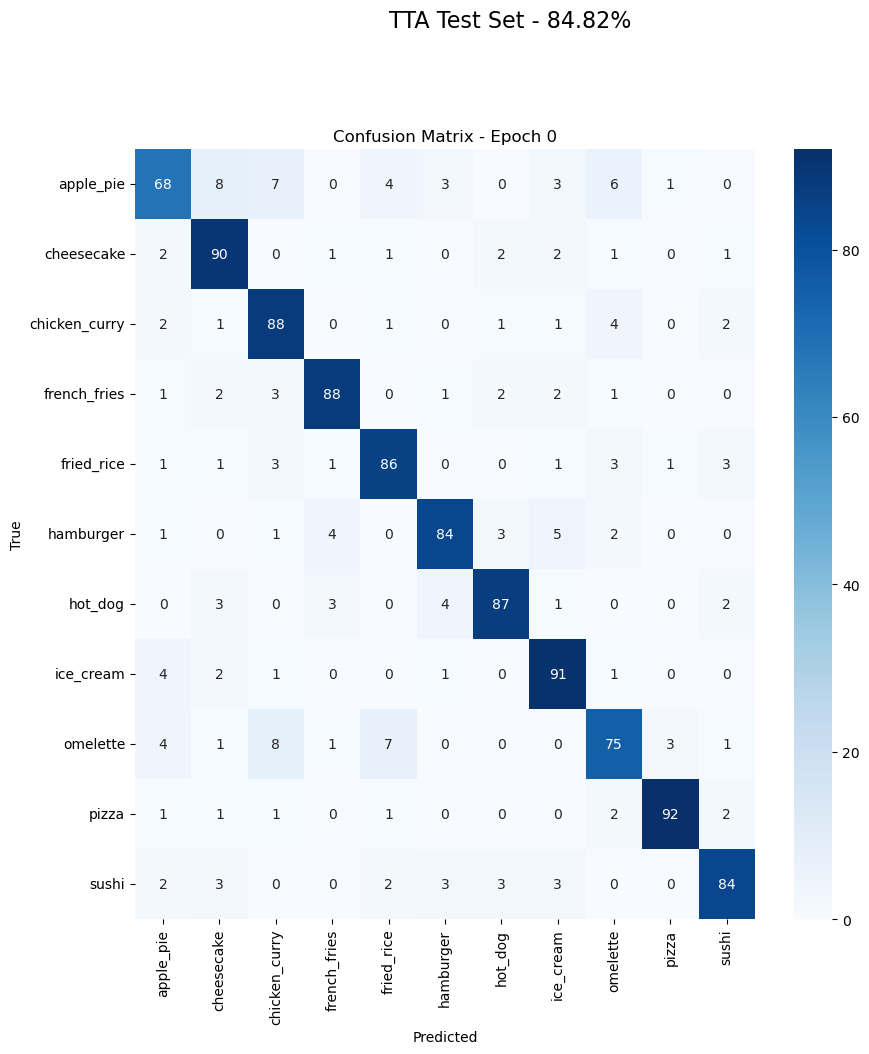

In [23]:
cm_tta = confusion_matrix(test_labels, test_preds)
cm_fig = plot_confusion_matrix(cm_tta, class_names, epoch=-1)
cm_fig.suptitle("TTA Test Set - 84.82%", fontsize=16, y=1.02)
cm_fig.savefig("FINAL_confusion_matrix_TTA_84.82%.png", dpi=200, bbox_inches='tight')
plt.show()

In [26]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset
from collections import Counter

data_dir = "food11"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

batch_size = 32
num_epochs = 50  # Увеличили — будем дообучать глубже
learning_rate_classifier = 1e-3
learning_rate_features = 1e-6  # Меньше для размороженных слоёв

patience = 7  # Больше терпения при fine-tuning
best_acc = 0.0
patience_counter = 0

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
full_train_clean = datasets.ImageFolder(train_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split на train/val (80/20)
train_size = int(0.8 * len(full_train_augmented))
val_size = len(full_train_augmented) - train_size

indices = list(range(len(full_train_augmented)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_train_augmented, train_indices)
val_dataset = Subset(full_train_clean, val_indices)

num_classes = len(full_train_augmented.classes)
class_names = full_train_augmented.classes
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Классы ({num_classes}): {class_names}")

train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
print("Распределение классов в train:", class_counts)

# Вычисляем веса для каждого класса
class_weights = [len(train_labels) / (num_classes * class_counts[i]) for i in range(num_classes)]
sample_weights = [class_weights[label] for label in train_labels]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name or "features.8" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Проверка
print("Обучаемые параметры:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  [Train] {name}")

model = model.to(device)

optimizer = optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if "features.7" in n or "features.8" in n], 'lr': 1e-6},
    {'params': model.classifier.parameters(), 'lr': 3e-4}
], weight_decay=1e-4)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.tensor(class_weights).to(device))

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

writer = SummaryWriter(log_dir="runs/food11_efficientnet_B5")

def plot_confusion_matrix(cm, class_names, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - Epoch {epoch+1}')
    return fig

def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels, cm

start_time = time.time()
print("\nОбучение (fine-tuning + label smoothing + weighted sampling)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_cm = evaluate_model(model, val_loader, criterion, device)

    # Логи
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)
    writer.add_scalar("Precision/Validation", val_prec, epoch)
    writer.add_scalar("Recall/Validation", val_rec, epoch)
    writer.add_scalar("F1/Validation", val_f1, epoch)
    writer.add_scalar("Learning_Rate_Classifier", optimizer.param_groups[1]['lr'], epoch)
    writer.add_scalar("Learning_Rate_Features", optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        cm_fig = plot_confusion_matrix(val_cm, class_names, epoch)
        writer.add_figure("Confusion_Matrix/Validation", cm_fig, epoch)
        plt.close(cm_fig)

    scheduler.step(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time
    est_remaining = (elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train: L={avg_train_loss:.3f} A={train_acc:.1f}% | "
          f"Val: L={val_loss:.3f} A={val_acc:.1f}% | "
          f"LR_c={optimizer.param_groups[1]['lr']:.2e} LR_f={optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {epoch_time:.0f}s | ETA: {est_remaining/60:.1f}min")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }, "efficientnet_B5_food11.pth")
        print(f"Лучшая модель сохранена! Val Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Нет улучшения {patience_counter}/{patience} эпох")
        if patience_counter >= patience:
            print(f"\nОстановка на эпохе {epoch+1}")
            print(f"Лучший результат: {best_acc:.2f}%")
            break


print("Финальная оценка на Test Set...")
checkpoint = torch.load("efficientnet_B5_food11.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc:.2f}% | Precision: {test_prec:.3f} | Recall: {test_rec:.3f} | F1: {test_f1:.3f}")

# Сохраняем матрицу
cm_fig = plot_confusion_matrix(test_cm, class_names, -1)
cm_fig.savefig("confusion_matrix_test_В5.png")
plt.close(cm_fig)
print("Confusion matrix сохранена: confusion_matrix_test_B5.png")

total_time = time.time() - start_time
print(f"Общее время: {total_time/60:.1f} минут")
print(f"Лучшая Val Accuracy: {best_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Модель сохранена: efficientnet_B5_food11.pth")

writer.close()

Устройство: mps
Train: 7920 | Val: 1980 | Test: 1100
Классы (11): ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Распределение классов в train: Counter({2: 735, 6: 729, 5: 728, 0: 727, 10: 721, 9: 720, 4: 717, 8: 716, 1: 712, 7: 708, 3: 707})
Обучаемые параметры:
  [Train] features.6.0.block.0.0.weight
  [Train] features.6.0.block.0.1.weight
  [Train] features.6.0.block.0.1.bias
  [Train] features.6.0.block.1.0.weight
  [Train] features.6.0.block.1.1.weight
  [Train] features.6.0.block.1.1.bias
  [Train] features.6.0.block.2.fc1.weight
  [Train] features.6.0.block.2.fc1.bias
  [Train] features.6.0.block.2.fc2.weight
  [Train] features.6.0.block.2.fc2.bias
  [Train] features.6.0.block.3.0.weight
  [Train] features.6.0.block.3.1.weight
  [Train] features.6.0.block.3.1.bias
  [Train] features.6.1.block.0.0.weight
  [Train] features.6.1.block.0.1.weight
  [Train] features.6.1.block.0.1.bias
  [Tr

Epoch 01/50 | Train: L=2.130 A=39.8% | Val: L=1.832 A=64.2% | LR_c=1.54e-05 LR_f=1.46e-07 | Time: 1133s | ETA: 925.6min
Лучшая модель сохранена! Val Acc: 64.19%


KeyboardInterrupt: 

In [ ]:
# Замени финальную оценку:
test_preds = tta_predict(model, test_loader, device, num_augs=5)
test_labels = [label for _, label in test_loader.dataset]
test_acc = 100.0 * np.mean(np.array(test_preds) == np.array(test_labels))
print(f"TTA Test Accuracy: {test_acc:.2f}%")

In [ ]:
cm_tta = confusion_matrix(test_labels, test_preds)
cm_fig = plot_confusion_matrix(cm_tta, class_names, epoch=-1)
cm_fig.suptitle("TTA Test Set - 84.82%", fontsize=16, y=1.02)
cm_fig.savefig("FINAL_confusion_matrix_TTA_84.82%.png", dpi=200, bbox_inches='tight')
plt.show()